In [1]:
import cv2
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

In [2]:
e_path1 = 'BC_Grade1/BC_IDC_Grade_1/Samples/enhanced'
e_path2 = 'BC_Grade2/BC_IDC_Grade_2/Samples/enhanced'
e_path3 = 'BC_Grade3/BC_IDC_Grade_3/Samples/enhanced'

In [3]:
def load_images_from_folder(folder_path, target_size=(224, 224)):
    image_files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f)) and f.endswith(('.JPG', '.jpg'))]
    images = []

    for image_file in image_files:
        img_path = os.path.join(folder_path, image_file)
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img_resized = cv2.resize(img, target_size)   
            images.append(img_resized)
    
    return np.array(images)

In [4]:
BCStage1 = load_images_from_folder(e_path1)
BCStage2 = load_images_from_folder(e_path2)
BCStage3 = load_images_from_folder(e_path3)

labels_stage1 = np.zeros((BCStage1.shape[0],)) 
labels_stage2 = np.ones((BCStage2.shape[0],))    
labels_stage3 = 2 * np.ones((BCStage3.shape[0],)) 

X = np.concatenate([BCStage1, BCStage2 ,BCStage3 ], axis=0)
y = np.concatenate([labels_stage1, labels_stage2, labels_stage3], axis=0)

In [5]:
X_train, X_test_temp, y_train, y_test_temp = train_test_split(X, y, test_size=0.2, random_state=36)

In [6]:
X_val, X_test, y_val, y_test = train_test_split(X_test_temp, y_test_temp, test_size=0.5, random_state=36)

In [7]:
dataAug = ImageDataGenerator(
    rotation_range=40,            
    width_shift_range=0.2,        
    height_shift_range=0.2,      
    shear_range=0.2,             
    zoom_range=[1.0, 1.2],              
    horizontal_flip=True, 
    rescale=1./255
)

In [8]:
dataAug.fit(X_train)

In [9]:
X_train = preprocess_input(X_train)
X_val = preprocess_input(X_val)
X_test = preprocess_input(X_test)

In [10]:
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [ ]:
for layer in base_model.layers:
    layer.trainable = False
       
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x) 
x = Dense(3, activation='softmax')(x)  
DNmodel = Model(base_model.input, x)
DNmodel.summary()

In [11]:
for layer in base_model.layers:
    layer.trainable = False
    
DNmodel = Sequential()
DNmodel.add(base_model)
DNmodel.add(GlobalAveragePooling2D())
DNmodel.add(Dense(512, activation='relu'))
DNmodel.add(BatchNormalization())
DNmodel.add(Dropout(0.5))
DNmodel.add(Dense(3, activation='softmax'))

DNmodel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 global_average_pooling2d (  (None, 1024)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 512)               524800    
                                                                 
 batch_normalization (Batch  (None, 512)               2048      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 3)                 1

In [12]:
DNmodel.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [14]:
DNmodel.fit( X_train, y_train,
           validation_data=(X_val, y_val),
           epochs=10,
           batch_size=32)

Epoch 1/10
24/24 [==============================] - 55s 2s/step - loss: 1.4677 - accuracy: 0.4247 - val_loss: 2.9692 - val_accuracy: 0.2935
Epoch 2/10
24/24 [==============================] - 49s 2s/step - loss: 1.0434 - accuracy: 0.5794 - val_loss: 1.5772 - val_accuracy: 0.3478
Epoch 3/10
24/24 [==============================] - 48s 2s/step - loss: 0.8818 - accuracy: 0.6242 - val_loss: 2.4547 - val_accuracy: 0.3587
Epoch 4/10
24/24 [==============================] - 49s 2s/step - loss: 0.8471 - accuracy: 0.6350 - val_loss: 1.1931 - val_accuracy: 0.4674
Epoch 5/10
24/24 [==============================] - 49s 2s/step - loss: 0.7881 - accuracy: 0.6459 - val_loss: 1.5805 - val_accuracy: 0.4674
Epoch 6/10
24/24 [==============================] - 50s 2s/step - loss: 0.6894 - accuracy: 0.7178 - val_loss: 1.3167 - val_accuracy: 0.5870
Epoch 7/10
24/24 [==============================] - 51s 2s/step - loss: 0.7049 - accuracy: 0.6744 - val_loss: 0.9856 - val_accuracy: 0.6087
Epoch 8/10
24/24 [==

In [15]:
test_loss, test_accuracy = DNmodel.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy*100:.2f}%")

3/3 [==============================] - 6s 2s/step - loss: 0.9871 - accuracy: 0.6237
Test accuracy: 62.37%


In [16]:
predictions = DNmodel.predict(X_test)  
predicted_classes = np.argmax(predictions, axis=1)
true_classes = y_test

f1 = f1_score(true_classes, predicted_classes, average='weighted')
print("F1 Score:", f1)

3/3 [==============================] - 7s 2s/step
F1 Score: 0.6181637004078605


3/3 [==============================] - 5s 2s/step


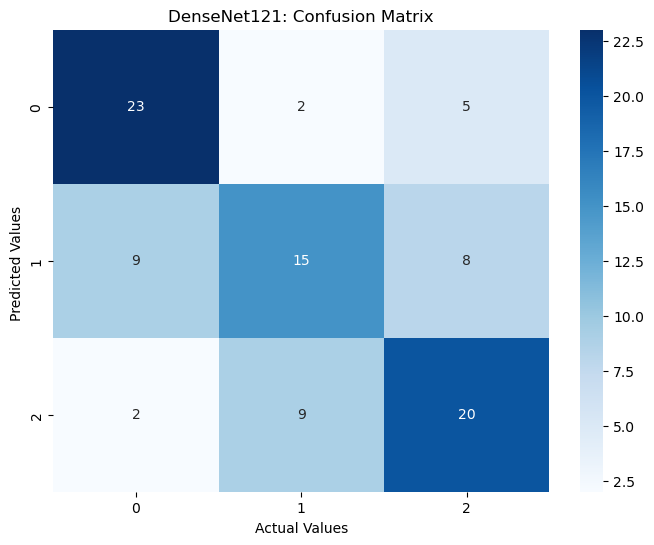

In [17]:
predictions = DNmodel.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)
conf_matrix = confusion_matrix(y_test, predicted_labels)

class_names = ['0', '1', '2'] 
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values ')
plt.title('DenseNet121: Confusion Matrix')
plt.show()

3/3 [==============================] - 5s 2s/step


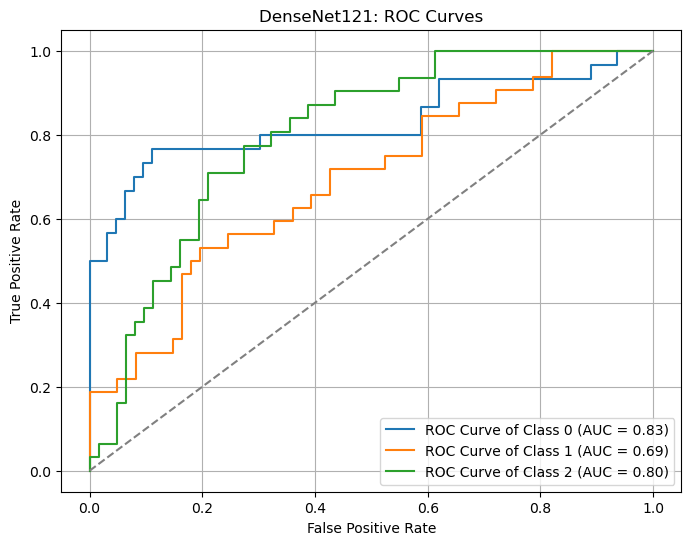

In [18]:
y_pred_prob = DNmodel.predict(X_test)

num_classes = y_pred_prob.shape[1]
fpr = {}
tpr = {}
auc = {}
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test == i, y_pred_prob[:, i])
    auc[i] = roc_auc_score(y_test == i, y_pred_prob[:, i])

plt.figure(figsize=(8, 6))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC Curve of Class {i} (AUC = {auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('DenseNet121: ROC Curves')
plt.legend()
plt.grid()
plt.show()